## Import Packages and Reading of Data

In [28]:
import time
import warnings
import pickle
import shap

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb # recommended version: 1.5.0

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import plot_importance
from sklearn.naive_bayes import GaussianNB
from bayes_opt import BayesianOptimization
from sklearn.ensemble import StackingClassifier

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [29]:
# Reading of Excel
dataset = pd.read_csv('cleaned_others_dataset.csv')

In [30]:
dataset

,protected,verified,location,followers_count,following_count,tweet_count,is_quoted_retweets,isFraud,un_no_of_char,un_special_char,un_uppercase,name_no_of_char,name_special_char,name_uppercase,des_no_of_usertags,des_no_of_hashtags,des_external_links,has_description,account_age_in_days,average_tweets_per_day
0,False,0,0,1997,5,17090,0,1,15,1,0,19,0,1,2,0,0,1,2184,7.825092
1,False,0,1,785,829,251,0,0,12,0,1,8,0,1,0,0,0,1,2159,0.116258
2,False,0,0,243,1232,1469,0,0,8,0,1,11,0,0,0,0,0,1,1939,0.757607
3,False,0,1,749,838,2518,1,0,11,0,1,15,0,1,0,0,0,1,2270,1.109251
4,False,1,1,737048,128,4739,0,0,13,0,1,14,0,1,1,0,0,1,3919,1.209237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33581,False,1,1,367523,17291,24084,1,0,14,0,1,10,0,1,2,0,0,1,4704,5.119898
33582,False,0,1,14,0,238,1,0,8,1,1,8,0,1,0,0,0,1,4289,0.055491
33583,False,0,0,395,492,21437,0,1,14,0,1,16,0,1,0,0,0,1,3792,5.653217
33584,False,0,0,159,618,3021,0,0,8,0,1,14,0,1,0,0,0,0,2659,1.136141


## Feature Engineering
* Scale numerical features
* One Hot Encode for categorical/ordinal features

In [31]:
# Getting X and y
x = dataset.drop(columns = ['isFraud'])
y = dataset['isFraud']

# Split into training and testing sets before scaling the variables and performing one hot encoding to avoid data leakage
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=101)
print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

Train set: (26868, 19) (26868,)
Test set: (6718, 19) (6718,)


In [32]:
# # We only want to scale the numeric variables and not the categorical features. 
# # Hence, we create a columntransformer to help us to do this
# scaler = StandardScaler()

# x_train[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char', 'name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']] = scaler.fit_transform(x_train[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']])

# x_test[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char', 'name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']] = scaler.transform(x_test[['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags']])

# # Transform the year column into a categorical variable and store the result in a dataframe
# encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
# transformed_year_train_matrix = encoder.fit_transform(x_train[['year']])
# transformed_year_train = pd.DataFrame(transformed_year_train_matrix, columns = encoder.get_feature_names())

# # Using the fitted encoder to transform the test data and storing in a dataframe
# transformed_year_test_matrix = encoder.transform(x_test[['year']])
# transformed_year_test = pd.DataFrame(transformed_year_test_matrix, columns = encoder.get_feature_names())

# # Reset the index for training and testing sets to allow merging with the one hot encoded variables
# # Drop the index column 
# x_train.reset_index(inplace = True, drop = True)
# x_test.reset_index(inplace = True, drop = True)
# y_train.reset_index(drop = True, inplace = True)
# y_test.reset_index(drop = True, inplace = True)

# # Combine the scaled numeric variables together with the year categorical variables
# x_train = pd.concat([x_train, transformed_year_train], axis = 1)
# x_test = pd.concat([x_test, transformed_year_test], axis = 1)

# # Drop the year column since we already have the dummy variables for year
# x_train.drop(labels = ['year'], axis = 1, inplace = True)
# x_test.drop(labels = ['year'], axis = 1, inplace = True)

In [33]:
# A class that combines all the preprocessing steps (for model pipeline purpose)
class ExperimentalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, numeric_variables = ['followers_count', 'following_count', 'tweet_count', 'un_no_of_char','name_no_of_char', 'des_no_of_usertags', 'des_no_of_hashtags', 'account_age_in_days', 'average_tweets_per_day']):
        self.encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
        self.scaler = StandardScaler()
        #specified numeric variables, by default it is the above
        self.numeric_variables = numeric_variables
        self.columns = []
    
    #The fit function that will be called when this custom transformer is fit
    def fit(self, X, y = None):
        #fit the one hot encoder to the year
#         self.encoder.fit(X[['year']])
        #fit the scaler on the numeric variables
        self.scaler.fit(X[self.numeric_variables])
        return self
    
    #The transform function that will be called
    def transform(self, X, y = None):
        
        #to avoid changing the original dataset
        X_ = X.copy()
        #transforming the numeric variables according to the fitted scaler
        X_[self.numeric_variables] = self.scaler.transform(X_[self.numeric_variables])
        
#         #next, create a date matrix using the fitted encoder
#         transformed_year_matrix = self.encoder.transform(X_[['year']])
#         #get the dataframe
#         year_cols = list(map(lambda year: year.replace('x0', 'year'), self.encoder.get_feature_names()))
#         transformed_year_train = pd.DataFrame(transformed_year_matrix, columns = year_cols)
#         #reset the index of the original dataframe
#         X_.reset_index(drop = True, inplace = True)
#         X_ = pd.concat([X_, transformed_year_train], axis = 1)
#         #drop the year column from the dataframe
#         X_.drop(labels = ['year'], inplace = True, axis = 1)
        self.columns = X_.columns
        return X_

## Charts

In [7]:
# def feature_chart(shap_values, x_test_values, names, model_type):
# #     feature_importance_df = pd.DataFrame(model.coef_.T, x_train.columns.T,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
# #     fig = feature_importance_df.plot(kind="barh", figsize=(20, 50))
# #     bg = fig.patch
# #     plt.gca().invert_yaxis()
#     shap.summary_plot(shap_values, x_test_values, feature_names = names, plot_type = "bar", sort = True)
#     plt.grid()
# #     plt.savefig(f'Charts\\{model_type} Feature Importance.png', dpi=300)
#     plt.show()

# model = SVC()
# model.fit(x_train, y_train)
# explainer = shap.Explainer(model.predict, x_test, feature_perturbation="interventional")
# shap_values = explainer(x_test)
# x_test_arr = x_test.toarray()
# feature_chart(shap_values, x_test_arr, x_test.columns, model_type)
    
def feature_chart(feature_importance_df, model_type):
#     feature_importance_df = pd.DataFrame(model.coef_.T, x_train.columns.T,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
    fig = feature_importance_df.plot(kind="barh", figsize=(12, 15))
    bg = fig.patch
    bg.set_facecolor("white")
    plt.gca().invert_yaxis()
    plt.grid()
#     plt.savefig(f'Charts\\{model_type} Feature Importance.png', dpi=300, facecolor=fig.get_facecolor())
    plt.show()

## 01 Logistic Regression
* Model 
* Error Metrics
* Plot for Feature Importance

In [10]:
# Model
log_regression = LogisticRegression()
transformer = ExperimentalTransformer()
log_model_pipeline = make_pipeline(transformer, log_regression)
log_model = log_model_pipeline.fit(x_train, y_train)

In [ ]:
# Save the model to disk
# filename = '01 Logistic Regression.sav'
# pickle.dump(log_model, open(filename, 'wb'))

# Load the model from disk
# results_random = pickle.load(open(filename, 'rb'))

In [11]:
# R-Squared
log_model.score(x_train, y_train)

0.7448265594759566

In [12]:
# y_prediction
y_pred = log_model.predict(x_test)

In [13]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred)
print(f'Recall: {recall}')

Log Loss: 8.42138677482952
ROC AUC: 0.6839353549998228
F1-score: 0.5608579088471849
Precision: 0.6987307949231797
Recall: 0.46842812360053737


### Feature Importance

In [ ]:
# Feature importance
feature = pd.DataFrame(log_model.named_steps["logisticregression"].coef_.T, log_model.named_steps["experimentaltransformer"].columns, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

In [ ]:
# Feature importance
feature_chart(feature, "Logistic Regression")

## 02 Random Forest
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

### Model (Random Search)

In [ ]:
# Model
rf_classifier = RandomForestClassifier()
transformer = ExperimentalTransformer()
rf_model = make_pipeline(transformer, rf_classifier)

space = dict()

# Number of trees in random forest
space["randomforestclassifier__n_estimators"] = [10, 50, 200, 600, 800, 1200]

# Number of features to consider at every split (this parameter avoids overfitting by limiting how many features each leaf node can look at) 
space["randomforestclassifier__max_features"] = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree (how deep the tree goes)
space["randomforestclassifier__max_depth"] = [None, 10, 40, 80, 120]

# Minimum number of samples required to split a node
space["randomforestclassifier__min_samples_split"] = [2, 10, 40, 100]

# Method of selecting samples for training each tree (bootstrap sampling or not)
space["randomforestclassifier__bootstrap"] = [True, False]

# Define search
random_search = RandomizedSearchCV(rf_model, 
                                   space, 
                                   scoring = 'f1',
                                   cv = 5, 
                                   verbose=2, 
                                   random_state=123, 
                                   n_jobs = -1)

In [ ]:
%%time

# Execute search
results_random_rf = random_search.fit(x_train, np.ravel(y_train))

In [ ]:
# Save the model to disk
# filename = '02 Random Forest (random).sav'
# pickle.dump(results_random, open(filename, 'wb'))

# Load the model from disk
# results_random = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_random_rf.best_score_)
print('Best Hyperparameters: %s' % results_random_rf.best_params_)

In [ ]:
# y_prediction for the best model using RandomSearchCV
y_pred_random = results_random_rf.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')

### Model (Grid Search)

In [ ]:
# Model
rf_classifier = RandomForestClassifier()
transformer = ExperimentalTransformer()
rf_model = make_pipeline(transformer, rf_classifier)

grid = dict()

# Number of trees in random forest
grid["randomforestclassifier__n_estimators"] = [10, 50, 200, 600, 800, 1200]

# Number of features to consider at every split
grid["randomforestclassifier__max_features"] = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree (how deep the tree goes)
grid["randomforestclassifier__max_depth"] = [None, 10, 40, 80, 120]

# Minimum number of samples required to split a node
grid["randomforestclassifier__min_samples_split"] = [2, 10, 40, 100]

# Method of selecting samples for training each tree (bootstrap sampling or not)
grid["randomforestclassifier__bootstrap"] = [True, False]

# Define search
grid_search = GridSearchCV(rf_model, 
                           grid, 
                           scoring = 'f1',
                           cv = 5, 
                           n_jobs = -1, 
                           verbose = 2)

In [ ]:
%%time

# Execute search
results_grid_rf = grid_search.fit(x_train, np.ravel(y_train))

In [ ]:
# Save the model to disk
# filename = '02 Random Forest (grid).sav'
# pickle.dump(results_grid, open(filename, 'wb'))

# Load the model from disk
# results_grid = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_grid_rf.best_score_)
print('Best Hyperparameters: %s' % results_grid_rf.best_params_)

In [ ]:
# y_prediction for the best model using GridSearchCV
y_pred_grid = results_grid_rf.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

### Model (Optimal Hyperparameters)

In [ ]:
print("Grid Search:", grid_search_rf.best_score_) 
print("Randomised Search:", random_search_rf.best_score_) 

In [ ]:
# Model (initialise the object based on parameters selected by grid search)
rf_classifier = RandomForestClassifier(bootstrap=True, max_depth=80, max_features='auto', min_samples_split=2, n_estimators=800)
transformer = ExperimentalTransformer()
rf_model_pipeline = make_pipeline(transformer, rf_classifier)
rf_model = rf_model_pipeline.fit(x_train, np.ravel(y_train))

# Save the model to disk
# filename = '02 Random Forest (Optimal).sav'
# pickle.dump(rf_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

In [ ]:
# y_prediction for the best model
y_pred_optimal = rf_model.predict(x_test)

In [ ]:
# Error Metrics
mae = metrics.accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy: {mae}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')

### Feature Importance

In [ ]:
# rf_model.feature_importances_
feature = pd.DataFrame(rf_model.named_steps["randomforestclaasifier"].feature_importances_, rf_model.named_steps["experimentaltransformer"].columns.columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

In [ ]:
feature_chart(feature, "Random Forest")

## 03 XGBoost
* Model (Random Search + Grid Search + Bayesian Optimisation)
* Error Metrics
* Plot for Feature Importance

### Model (Random Search)

In [ ]:
xgb_classifier = xgb.XGBClassifier(gamma = 0.1,
                                   alpha = 0.5,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")
transformer = ExperimentalTransformer()
xgb_model = make_pipeline(transformer, xgb_classifier)

space = dict()

# Maximum depth of the individual regression estimators
space["xgbclassifier__max_depth"] = [6, 10, 15, 20, 25]

# Fraction of samples to be used for fitting the individual base learners
space["xgbclassifier__subsample"] = [0.6, 0.8, 1.0]

# Step size shrinkage used in update to prevents overfitting
space["xgbclassifier__eta"] = [0.01, 0.1, 0.2]

# Subsample ratio of columns when constructing each tree
space["xgbclassifier__colsample_bytree"] = [0.5, 0.6, 0.7, 0.8, 0.9]

# Define Search
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=parameters,
                                   scoring = 'f1',
                                   n_jobs = -1,
                                   cv = 5,
                                   verbose=10,
                                   n_iter=50,
                                   random_state=123)

In [ ]:
%%time

# Execute Search
results_random_xgb = random_search.fit(x_train, y_train)
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# CPU times: user 1min 23s, sys: 3.7 s, total: 1min 27s
# Wall time: 1h 29min 45s

In [ ]:
# filename = 'random_all.sav'
# pickle.dump(random_search, open(filename, 'wb'))

print('Best Score: %s' % results_random_xgb.best_score_)
print('Best Hyperparameters: %s' % results_random_xgb.best_params_)

# print(results_random.best_params_)
# print("Randomised Search:", results_random.best_score_)

In [ ]:
# y_prediction for the best model using RandomSearchCV
y_pred_random = results_random_xgb.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')

### Model (Grid Search)

In [ ]:
xgb_classifier = xgb.XGBClassifier(gamma = 0.1,
                                   alpha = 0.5,
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")
transformer = ExperimentalTransformer()
xgb_model = make_pipeline(transformer, xgb_classifier)

grid = dict()

# Maximum depth of the individual regression estimators
grid["xgbclassifier__max_depth"] = [6, 10, 15, 20, 25]

# Fraction of samples to be used for fitting the individual base learners
grid["xgbclassifier__subsample"] = [0.6, 0.8, 1.0]

# Step size shrinkage used in update to prevents overfitting
grid["xgbclassifier__eta"] = [0.01, 0.1, 0.2]

# Subsample ratio of columns when constructing each tree
grid["xgbclassifier__colsample_bytree"] = [0.5, 0.6, 0.7, 0.8, 0.9]

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=parameters,
                           scoring = 'f1',
                           n_jobs = -1,
                           cv = 5,
                           verbose=True)

In [ ]:
%%time

results_grid_xgb = grid_search.fit(x_train, y_train)
# Fitting 5 folds for each of 225 candidates, totalling 1125 fits
# CPU times: user 2min 51s, sys: 15.3 s, total: 3min 6s
# Wall time: 6h 58min 5s

In [ ]:
print('Best Score: %s' % results_grid_xgb.best_score_)
print('Best Hyperparameters: %s' % results_grid_xgb.best_params_)

In [ ]:
# y_prediction for the best model using GridSearchCV
y_pred_grid = results_grid_xgb.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

### Model (Bayesian Optimisation)

In [34]:
def xgboost_hyper_pram(eta, max_depth, subsample, gamma, colsample_bytree, alpha):
    max_depth = int(max_depth)
    xgb_classifier = xgb.XGBClassifier(max_depth = max_depth, 
                                       eta = eta, 
                                       gamma = gamma,
                                       subsample = subsample,
                                       colsample_bytree = colsample_bytree,
                                       alpha = alpha,
                                       objective = "binary:logistic",
                                       eval_metric = "logloss")

    transformer = ExperimentalTransformer()
    xgb_model = make_pipeline(transformer, xgb_classifier)
    
    xgb_model.fit(x_train, y_train)
    y_pred = xgb_model.predict(x_test)
    
    return (metrics.f1_score(y_test, y_pred))

In [35]:
optim_model = BayesianOptimization(xgboost_hyper_pram, 
                                   {'max_depth' : (1, 30), 
                                   'eta' : (0, 0.2), 
                                   'gamma' : (0, 1),
                                   'subsample' : (0, 1),
                                   'colsample_bytree' : (0, 1),
                                   'alpha' : (0, 1)},
                                   random_state=123)

In [36]:
%%time 

optim_model.maximize(n_iter=15, init_points=25, acq='ei')

# CPU times: user 22min 42s, sys: 3.66 s, total: 22min 46s
# Wall time: 22min 41s

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.7616    | 0.6965    | 0.2861    | 0.04537   | 0.5513    | 21.86     | 0.4231    |
| 2         | 0.7829    | 0.9808    | 0.6848    | 0.09619   | 0.3921    | 10.95     | 0.729     |
| 3         | 0.6706    | 0.4386    | 0.05968   | 0.07961   | 0.738     | 6.292     | 0.1755    |
| 4         | 0.7747    | 0.5316    | 0.5318    | 0.1269    | 0.8494    | 22.01     | 0.611     |
| 5         | 0.7733    | 0.7224    | 0.323     | 0.07236   | 0.2283    | 9.518     | 0.631     |
| 6         | 0.7721    | 0.0921    | 0.4337    | 0.08617   | 0.4937    | 13.35     | 0.3123    |
| 7         | 0.7568    | 0.4264    | 0.8934    | 0.1888    | 0.5018    | 19.09     | 0.1156    |
| 8         | 0.7724    | 0.3173    | 0.4148    | 0.1733    | 0.2505    | 15.01     | 0.9856    |
| 9         | 0.7757

In [37]:
print('Best Score: %s' % optim_model.max["target"])
print('Best Hyperparameters: %s' % optim_model.max['params'])

Best Score: 0.7867275787448906
Best Hyperparameters: {'alpha': 0.7049588304513622, 'colsample_bytree': 0.9953584820340174, 'eta': 0.07118297314349191, 'gamma': 0.7625478137854338, 'max_depth': 18.202130580304413, 'subsample': 0.6917017987001771}


### Model (Optimal Hyperparameters)

In [18]:
print("Grid Search:", grid_search_xbg.best_score_) 
print("Randomised Search:", random_search_xgb.best_score_) 
print("Bayesian Optimisation:", optim_model.max["target"]) 

NameError: name 'grid_search_xbg' is not defined

In [38]:
#Tuned hyperparameters using 
# params = grid_search.best_params_
params = optim_model.max['params']
xgb_classifier = xgb.XGBClassifier(max_depth = int(params['max_depth']), 
                                   eta = params['eta'], 
                                   gamma = params['gamma'],
                                   subsample = params['subsample'],
                                   colsample_bytree = params['colsample_bytree'],
                                   alpha = params['alpha'],
                                   objective = "binary:logistic",
                                   eval_metric = "logloss")

transformer = ExperimentalTransformer()
xgb_model_pipeline = make_pipeline(transformer, xgb_classifier)
xgb_model = xgb_model_pipeline.fit(x_train, y_train)

In [39]:
# y_prediction for the best model
y_pred_optimal = xgb_model.predict(x_test)

In [40]:
# Error Metrics
mae = metrics.accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy: {mae}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')

Accuracy: 0.8679666567430783
F1-score: 0.7867275787448906
Precision: 0.8494288681204569
Recall: 0.7326466636811464


### Feature Importance

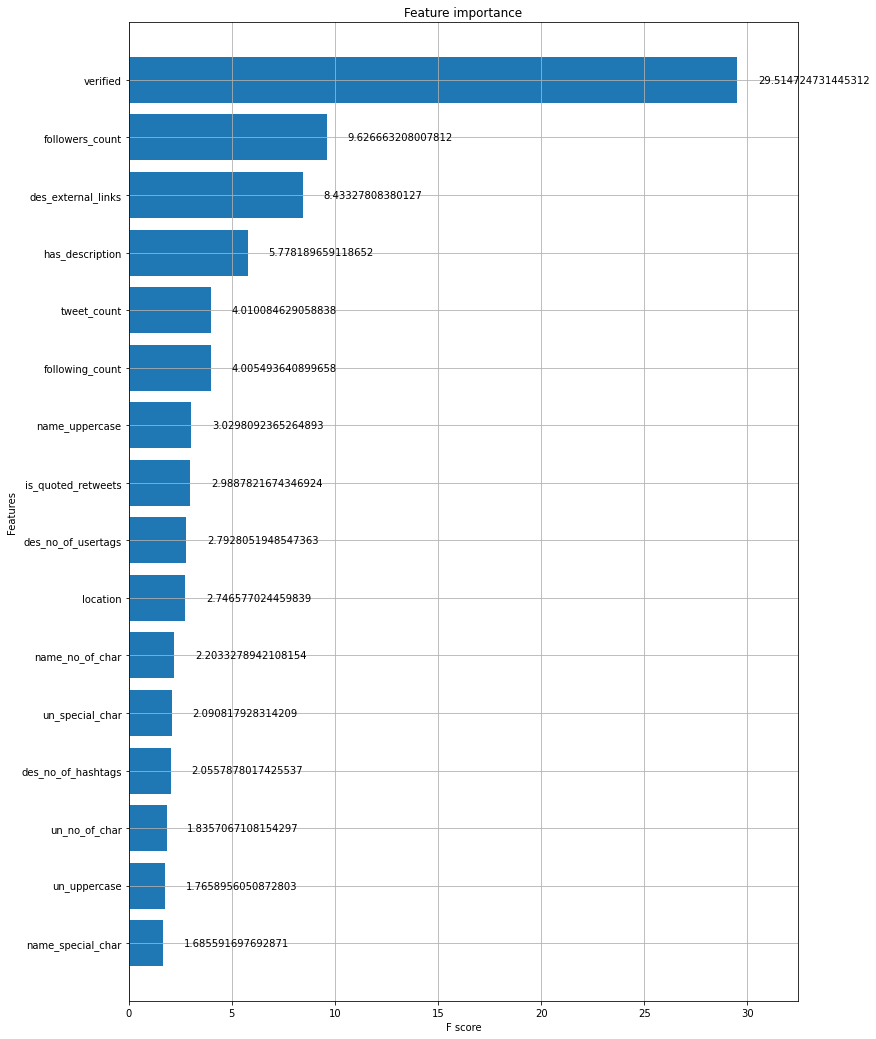

In [23]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model.named_steps["xgbclassifier"], importance_type = 'gain', height=0.8, ax=ax)
plt.show()

## 04 Support Vector Machine
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

### Model: Random Search

In [ ]:
# Model
svm_classifier = SVC()
transformer = ExperimentalTransformer()
svm_model = make_pipeline(transformer, svm_classifier)

space = dict()

# Kernel type to be used in the algorithm
space["svc__kernel"] = ['poly', 'rbf', 'sigmoid']

# Degree of the polynomial kernel function
space["svc__degree"] = [1, 3, 8]

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
space["svc__gamma"] = ['scale', 'auto']

# Regularisation parameter
space["svc__C"] = [0.1, 1, 10, 100]

# Enable verbose output
space["svc__verbose"] = [True, False]

# Define search
random_search = RandomizedSearchCV(svm_model, 
                                   space, 
                                   cv = 5, 
                                   scoring = 'f1',
                                   verbose = 2, 
                                   random_state = 123, 
                                   n_jobs = -1)

In [ ]:
%%time

# Execute search
results_random_svm = random_search.fit(x_train, np.ravel(y_train))

In [ ]:
# Save the model to disk
# filename = '04 SVM (Random).sav'
# pickle.dump(results_random, open(filename, 'wb'))

# Load the model from disk
# results_random = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_random_svm.best_score_)
print('Best Hyperparameters: %s' % results_random_svm.best_params_)

In [ ]:
# y_prediction for the best model using RandomSearchCV
y_pred_random = results_random_svm.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')

### Model: Grid Search

In [ ]:
# Model
svm_classifier = SVC()
transformer = ExperimentalTransformer()
svm_model = make_pipeline(transformer, svm_classifier)

grid = dict()

# Kernel type to be used in the algorithm
grid["svc__kernel"] = ['poly', 'rbf', 'sigmoid']

# Degree of the polynomial kernel function
grid["svc__degree"] = [1, 3, 8]

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
grid["svc__gamma"] = ['scale', 'auto']

# Regularisation parameter
grid["svc__C"] = [0.1, 1, 10, 100]

# Enable verbose output
grid["svc__verbose"] = [True, False]

# Define search
search = GridSearchCV(svm_model, 
                      grid, 
                      scoring = 'f1',
                      cv = 5, 
                      n_jobs = -1, 
                      verbose = 2)

In [ ]:
%%time

# Execute search
results_grid_svm = search.fit(x_train, np.ravel(y_train))

In [ ]:
# Save the model to disk
# filename = '04 SVM (Grid).sav'
# pickle.dump(results_grid, open(filename, 'wb'))

# Load the model from disk
# results_grid = pickle.load(open(filename, 'rb'))

print('Best Score: %s' % results_grid_svm.best_score_)
print('Best Hyperparameters: %s' % results_grid_svm.best_params_)

In [ ]:
# y_prediction for the best model using GridSearchCV
y_pred_grid = results_grid_svm.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')

### Model: Optimal Hyperparameters

In [ ]:
print("Grid Search:", grid_search_svm.best_score_) 
print("Randomised Search:", random_search_svm.best_score_) 

In [ ]:
# Model
# Best Hyperparameters (Random): {'svc__verbose': False, 'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__degree': 1, 'svc__C': 100}
# Best Hyperparameters (Grid): {'C': 10, 'degree': 8, 'gamma': 'scale', 'kernel': 'poly', 'verbose': True}
# random_state = 123
svm_classifier = SVC(C = 10, degree = 8, gamma = 'scale', kernel = 'poly', verbose = True, random_state = 123)
transformer = ExperimentalTransformer()
svm_model_pipeline = make_pipeline(transformer, svm_classifier)
svm_model = svm_model_pipeline.fit(x_train, np.ravel(y_train))

# Save the model to disk
# filename = '04 SVM (Optimal).sav'
# pickle.dump(svm_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

In [ ]:
# y_prediction for the best model
y_pred_optimal = svm_model.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_optimal)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')

### Feature Importance
* Cannot find cause black box model unless use SHAP or perm importance?

In [ ]:
# Feature importance
x_test_imps = svm_model.named_steps["experimentaltransformer"].transform(x_test)
imps = permutation_importance(svm_model.named_steps["svc"], x_test_imps, y_test, random_state=123)
feature = pd.DataFrame(imps.importances_mean, svm_model.named_steps["experimentaltransformer"].columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

In [ ]:
feature_chart(feature, "SVM")

# NEED TO EDIT ONCE JES REUPLOADS
## 05 Naive Bayes
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

### Model (Random)

In [ ]:
# Model
nb_classifier = GaussianNB()
transformer = ExperimentalTransformer()
nb_model = make_pipeline(transformer, nb_classifier)

space = dict()

# 
space["gaussiannb__var_smoothing"] = np.logspace(0,-9, num=200) 
    
random_search = RandomizedSearchCV(estimator=nb_model,
                                   param_distributions=space,
                                   scoring = 'f1',
                                   n_jobs=-1,
                                   cv=5,
                                   verbose=10,
                                   n_iter=50,
                                   random_state=123)

In [ ]:
%%time

result_random_nb = random_search.fit(x_train, y_train)

In [ ]:
print('Best Score: %s' % result_random_nb.best_score_)
print('Best Hyperparameters: %s' % result_random_nb.best_params_)

In [ ]:
y_pred_random = result_random_nb.predict(x_test)

In [ ]:
lg_loss = metrics.log_loss(y_test, y_pred_random)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_random)
print(f'ROC AUC: {roc_auc}')
precision = metrics.precision_score(y_test, y_pred_random)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_random)
print(f'Recall: {recall}')
f1_score = metrics.f1_score(y_test, y_pred_random)
print(f'F1-score: {f1_score}')

### Model (Grid)

In [ ]:
# Model
nb_classifier = GaussianNB()
transformer = ExperimentalTransformer()
nb_model = make_pipeline(transformer, nb_classifier)

grid = dict()

# 
grid["gaussiannb__var_smoothing"] = np.logspace(0,-9, num=200) 
    
grid_search = RandomizedSearchCV(estimator=nb_model,
                                 param_distributions=grid,
                                 scoring = 'f1',
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=10,
                                 n_iter=50,
                                 random_state=123)

In [ ]:
%%time

result_grid_nb = grid_search.fit(x_train, y_train)

In [ ]:
print('Best Score: %s' % result_grid_nb.best_score_)
print('Best Hyperparameters: %s' % result_grid_nb.best_params_)

In [ ]:
y_pred_grid = result_grid_nb.predict(x_test)

In [ ]:
lg_loss = metrics.log_loss(y_test, y_pred_grid)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_grid)
print(f'ROC AUC: {roc_auc}')
precision = metrics.precision_score(y_test, y_pred_grid)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_grid)
print(f'Recall: {recall}')
f1_score = metrics.f1_score(y_test, y_pred_grid)
print(f'F1-score: {f1_score}')

### Model (Optimal Hyperparameters)

In [ ]:
print("Grid Search:", grid_search_nb.best_score_) 
print("Randomised Search:", random_search_nb.best_score_) 

In [ ]:
# Model
# 
nb_classifier = GaussianNB(var_smoothing = 6.985879746785249e-06)
transformer = ExperimentalTransformer()
nb_model_pipeline = make_pipeline(transformer, nb_classifier)
nb_model = nb_model_pipeline.fit(x_train, np.ravel(y_train))

# Save the model to disk
# filename = '04 SVM (Optimal).sav'
# pickle.dump(svm_model, open(filename, 'wb'))

# Load the model from disk
# rf_regression = pickle.load(open(filename, 'rb'))

In [ ]:
# y_prediction for the best model
y_pred_optimal = nb_model.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_optimal)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_optimal)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_optimal)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_optimal)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_optimal)
print(f'Recall: {recall}')

### Feature Importance

In [ ]:
# Feature importance
x_test_imps = nb_model.named_steps["experimentaltransformer"].transform(x_test)
imps = permutation_importance(nb_model.named_steps["gaussiannb"], x_test_imps, y_test, random_state=123)
feature = pd.DataFrame(imps.importances_mean, nb_model.named_steps["experimentaltransformer"].columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature

In [ ]:
# Feature importance
feature_chart(feature, "GaussianNB")

## 06 Ensemble Model
* Model (Random Search + Grid Search)
* Error Metrics
* Plot for Feature Importance

In [ ]:
# Insert after getting optimal hyperparameters!!!!!
rf_classifier = RandomForestClassifier()
xgb_classifier = xgb.XGBClassifier()
svm_classifier = SVC()
log_regression = LogisticRegression()

transformer = ExperimentalTransformer()
rf_model_pipeline = make_pipeline(transformer, rf_classifier)
xgb_model_pipeline = make_pipeline(transformer, xgb_classifier)
svm_model_pipeline = make_pipeline(transformer, svm_classifier)

In [ ]:
clf = [rf_model_pipeline, xgb_model_pipeline, svm_model_pipeline]

for algo in clf:
    score = cross_val_score(algo, x_test, y_test, cv = 7, scoring = 'f1')
    print("The f1 score of {} is:".format(algo),score.mean())

clf = [('rfc', rf_model_pipeline), ('xgb', xgb_model_pipeline), ('svm', svm_model_pipeline)] #list of (str, estimator)

stack_model_pipeline = StackingClassifier(estimators = clf, final_estimator = log_regression)
score = cross_val_score(stack_model_pipeline, x_test, y_test, cv = 7, scoring = 'f1')
print(score)
print("The f1 score of is:", score.mean())

In [ ]:
%%time

stack_model = stack_model_pipeline.fit(x_train, y_train)

In [ ]:
stack_model

In [ ]:
y_pred_stack = stack_model.predict(x_test)

In [ ]:
# Error Metrics
lg_loss = metrics.log_loss(y_test, y_pred_stack)
print(f'Log Loss: {lg_loss}')
roc_auc = metrics.roc_auc_score(y_test, y_pred_stack)
print(f'ROC AUC: {roc_auc}')
f1_score = metrics.f1_score(y_test, y_pred_stack)
print(f'F1-score: {f1_score}')
precision = metrics.precision_score(y_test, y_pred_stack)
print(f'Precision: {precision}')
recall = metrics.recall_score(y_test, y_pred_stack)
print(f'Recall: {recall}')

### Feature Importance

In [ ]:
x_test_imps = stack_model.transform(x_test)

rf_class = stack_model.estimators_[0].named_steps["randomforestclassifier"]
xgb_class = stack_model.estimators_[1].named_steps["xgbclassifier"]
svm_class = stack_model.estimators_[2].named_steps["svc"]

rf_imps = permutation_importance(rf_class, x_test_imps, y_test, random_state=123)
xgb_imps = permutation_importance(xgb_class, x_test_imps, y_test, random_state=123)
svm_imps = permutation_importance(svm_class, x_test_imps, y_test, random_state=123)

In [ ]:
rf_xgb_imps = np.add(rf_imps.importances_mean, xgb_imps.importances_mean)
rf_xgb_svm_imps = np.add(rf_xgb_imps, svm_imps.importances_mean)

In [ ]:
# Feature importance
feature = pd.DataFrame(rf_xgb_svm_imps, x_test_imps.columns.T, columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)
feature